# Algorithmic trading with LSTM

We consider monthly means of prices of S&P500 index and use recurrent neural network of type LSTM to predict its price for the next month. In this way we are able to develop a good investing strategy and verify that, in a period of 4 years which comprehends 2008 crisis, it is far better than other three simpler strategies: buy and hold strategy, KISS strategy (buy when the current price is greater or equal to the moving average of 12 months and sell otherwise) and a custom strategy.

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import fix_yahoo_finance
from scipy.optimize import brute

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
start_date=datetime.datetime(1973, 1, 1)
end_date=datetime.datetime(2011, 12, 31)

In [3]:
df = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)
df.drop("Adj Close",axis=1,inplace=True)
print df.tail()

                   High          Low         Open        Close      Volume
Date                                                                      
2011-12-23  1265.420044  1254.000000  1254.000000  1265.329956  2233830000
2011-12-27  1269.369995  1262.300049  1265.020020  1265.430054  2130590000
2011-12-28  1265.849976  1248.640015  1265.380005  1249.640015  2349980000
2011-12-29  1263.540039  1249.750000  1249.750000  1263.020020  2278130000
2011-12-30  1264.119995  1257.459961  1262.819946  1257.599976  2271850000


 We obtain the dataframe of the monthly means 

In [4]:
dfm=df.resample("M").mean()
if df[str(end_date.year)+"-"+str(end_date.month)].shape[0]<=1:
    dfm=dfm[:-1]
print dfm.head()
print dfm.tail()

                  High         Low        Open       Close        Volume
Date                                                                    
1973-01-31  119.544761  117.500953  118.518572  118.421905  1.875000e+07
1973-02-28  115.360001  113.265263  114.395264  114.164211  1.674684e+07
1973-03-31  113.389547  111.349545  112.421363  112.415454  1.560909e+07
1973-04-30  111.285500  109.283501  110.496000  110.274000  1.389950e+07
1973-05-31  108.311818  105.961363  107.278637  107.219546  1.533000e+07
                   High          Low         Open        Close        Volume
Date                                                                        
2011-08-31  1205.768698  1166.730883  1188.300001  1185.305653  4.713877e+09
2011-09-30  1190.216198  1160.463792  1178.001418  1173.879057  4.894610e+09
2011-10-31  1217.194760  1189.630011  1201.559041  1207.216187  4.669699e+09
2011-11-30  1238.799520  1213.280971  1226.688570  1226.414772  4.013098e+09
2011-12-31  1253.018566  12

Since we want to confront the monthly means with the price of first day of the month, we need also to obtain the list of the first day of the months

In [5]:
start_year=start_date.year
start_month=start_date.month
end_year=end_date.year
end_month=end_date.month

first_days=[]
# First year
for month in range(start_month,13):
    first_days.append(min(df[str(start_year)+"-"+str(month)].index))
# Other years
for year in range(start_year+1,end_year):
    for month in range(1,13):
        first_days.append(min(df[str(year)+"-"+str(month)].index))
# Last year
for month in range(1,end_month+1):
    first_days.append(min(df[str(end_year)+"-"+str(month)].index))
if df.index[-1] not in first_days:
    first_days.append(df.index[-1])

In [6]:
dfm["fd_cm"]=first_days[:-1]
dfm["fd_nm"]=first_days[1:]
dfm["fd_cm_open"]=np.array(df.loc[first_days[:-1],"Open"])
dfm["fd_nm_open"]=np.array(df.loc[first_days[1:],"Open"])
dfm["rapp"]=dfm["fd_nm_open"].divide(dfm["fd_cm_open"])

Now for each month we have the means of the month, the open price of the first day of the current month and the open price of the first day of the next month.  
"rapp" is the quotient between the open price of the first day of the next month and the open price of the first day of the current month

In [7]:
print dfm.head()
print dfm.tail()

                  High         Low        Open       Close        Volume  \
Date                                                                       
1973-01-31  119.544761  117.500953  118.518572  118.421905  1.875000e+07   
1973-02-28  115.360001  113.265263  114.395264  114.164211  1.674684e+07   
1973-03-31  113.389547  111.349545  112.421363  112.415454  1.560909e+07   
1973-04-30  111.285500  109.283501  110.496000  110.274000  1.389950e+07   
1973-05-31  108.311818  105.961363  107.278637  107.219546  1.533000e+07   

                fd_cm      fd_nm  fd_cm_open  fd_nm_open      rapp  
Date                                                                
1973-01-31 1973-01-02 1973-02-01  118.059998  116.029999  0.982805  
1973-02-28 1973-02-01 1973-03-01  116.029999  111.680000  0.962510  
1973-03-31 1973-03-01 1973-04-02  111.680000  111.519997  0.998567  
1973-04-30 1973-04-02 1973-05-01  111.519997  106.970001  0.959200  
1973-05-31 1973-05-01 1973-06-01  106.970001  104.949

Now we add the columns corresponding to the moving averages at 1 and 2 years

In [8]:
dfm["mv_avg_12"]= dfm["Open"].rolling(window=12).mean().shift(1)
dfm["mv_avg_24"]= dfm["Open"].rolling(window=24).mean().shift(1)

Note that in this way each month of dfm contains the moving averages of the previous 12 and 24 months (excluding the current month)

In [9]:
print dfm.loc["1980-03","mv_avg_12"]
print dfm.loc["1979-03":"1980-02","Open"]
print dfm.loc["1979-03":"1980-02","Open"].mean()

Date
1980-03-31    105.29345
Freq: M, Name: mv_avg_12, dtype: float64
Date
1979-03-31     99.873636
1979-04-30    102.056000
1979-05-31     99.835000
1979-06-30    101.545238
1979-07-31    102.668571
1979-08-31    107.116521
1979-09-30    108.583684
1979-10-31    104.745652
1979-11-30    103.467143
1979-12-31    107.687000
1980-01-31    110.585454
1980-02-29    115.357501
Freq: M, Name: Open, dtype: float64
105.293450059


In [10]:
dfm=dfm.iloc[24:,:] # WARNING: DO IT JUST ONE TIME!
print dfm.index

DatetimeIndex(['1975-01-31', '1975-02-28', '1975-03-31', '1975-04-30',
               '1975-05-31', '1975-06-30', '1975-07-31', '1975-08-31',
               '1975-09-30', '1975-10-31',
               ...
               '2011-03-31', '2011-04-30', '2011-05-31', '2011-06-30',
               '2011-07-31', '2011-08-31', '2011-09-30', '2011-10-31',
               '2011-11-30', '2011-12-31'],
              dtype='datetime64[ns]', name=u'Date', length=444, freq='M')


We compare the methods on the last 72 months

In [11]:
mtest=72
dfm0=dfm.iloc[:-mtest,:] # This is the train set
dfm1=dfm.iloc[-mtest:,:] # This is the test set
print dfm0.shape
print dfm1.shape

(372, 12)
(72, 12)


## First we consider the custom method as in "Algorithmic trading pt.1"

In [12]:
def expand_islands2D(v):
    # Get start, stop of 1s islands
    v1 = np.r_[0,v,0]
    idx = np.flatnonzero(v1[:-1] != v1[1:])
    s0,s1 = idx[::2],idx[1::2]
    if len(s0)==0:
        return np.zeros(len(v)),0
    
    # Initialize 1D id array  of size same as expected o/p and has 
    # starts and stops assigned as 1s and -1s, so that a final cumsum
    # gives us the desired o/p
    N,M = len(s0),len(v)
    out = np.zeros(N*M,dtype=int)

    # Setup starts with 1s
    r = np.arange(N)*M
    out[s0+r] = 1


    # Setup stops with -1s
    if s1[-1] == M:
        out[s1[:-1]+r[:-1]] = -1
    else:
        out[s1+r] -= 1

    # Final cumsum on ID array
    out2D = out.cumsum().reshape(N,-1)
    return out2D,N

In [13]:
def lin_comb(df,a):
    lin_comb=df["fd_cm_open"]+a[0]*df["mv_avg_12"]+a[1]*df["mv_avg_24"]
    return lin_comb

def yield_prod(df,a):
    line_comb=lin_comb(df,a)
    v=np.maximum(0,np.sign(np.array(line_comb.values)))
    return (v*df["rapp"]+(1-v)).prod()

def compute_coeffs(df):
    
    def to_minimize(a):
        return -yield_prod(df,a)#-min_yield(gspc_train,a)
        
    ranges = (slice(-2, 0, 0.01),slice(-2, 0, 0.01),)

    resbrute = brute(to_minimize,ranges)
    
    return resbrute


def yield_prod_net(df,a):
    
    line_comb=lin_comb(df,a)
    v=np.maximum(0,np.sign(np.array(line_comb.values)))
    w,n=expand_islands2D(v)
    A=(w*np.array(df["rapp"])+(1-w)).prod(axis=1)
    #print v*df["rapp"]
    out=(np.sign(np.sign(1-A)+1)*A+0.74*np.maximum(0,np.sign(A-1))*A+0.26*np.maximum(0,np.sign(A-1)))
    return out.prod()*(0.999**(2*n))


def yield_prod_net2(df,v):
    
    w,n=expand_islands2D(v)
    A=(w*np.array(df["rapp"])+(1-w)).prod(axis=1)
    #print v*df["rapp"]
    out=(np.sign(np.sign(1-A)+1)*A+0.74*np.maximum(0,np.sign(A-1))*A+0.26*np.maximum(0,np.sign(A-1)))
    return out.prod()*(0.999**(2*n))
    

def compute_coeffs_net(df):
    
    def to_minimize_net(a):
        return -yield_prod_net(df,a)#-min_yield(gspc_train,a)
        
    ranges = (slice(-2, 0, 0.01),slice(-2, 0, 0.01),)

    resbrute = brute(to_minimize_net,ranges)
    
    return resbrute

In [14]:
start=time.time()
coeffs= compute_coeffs(dfm0)
print "Optimal coefficients: ",coeffs
print "Minutes of computation: ",(time.time()-start)/60

Optimal coefficients:  [-0.76 -0.01]
Minutes of computation:  1.08271388213


Buy and Hold method consists in buing and never moving

KISS method consists in confronting, the first day of each month, the current price with the mean of the price of the previous 12 months. If the current price is greater than the mean we stay in the market, otherwise we go out

Custom method consists in finding the best linear combination of the means at 12 and 24 months to confront with the Open price of the first day of the month in order to maximize the yield.

In [15]:
print "Gross yield Buy and Hold = ", (round(yield_prod(dfm1,[1,1]),3)-1)*100,"%"
print "Gross yield KISS = ",(round(yield_prod(dfm1,[-1,0]),3)-1)*100,"%"
print "Gross yield custom method = ",(round(yield_prod(dfm1,coeffs),3)-1)*100,"%"
print "\n"
print "Net yield Buy and Hold = ",(round(yield_prod_net(dfm1,[1,1]),3)-1)*100,"%"
print "Net yield KISS = ",(round(yield_prod_net(dfm1,[-1,0]),3)-1)*100,"%"
print "Net yield custom method = ",(round(yield_prod_net(dfm1,coeffs),3)-1)*100,"%"

Gross yield Buy and Hold =  1.2 %
Gross yield KISS =  23.7 %
Gross yield custom method =  12.3 %


Net yield Buy and Hold =  0.7 %
Net yield KISS =  14.9 %
Net yield custom method =  2.9 %


Note that the net yield is computed considering a 0.1% commission to the broker at each transaction and a 26% tax on capital gain (as it is by the Italian law)

We see that our custom method performed worse than the simpler KISS method: this is because it was trained in a period of growth and then tested in a difficult period (containing the 2008 crisis). Of course one should choose the strategy depending on the market (we should have trained our custom model on another difficult period) but then it would be necessary to forcast the market!

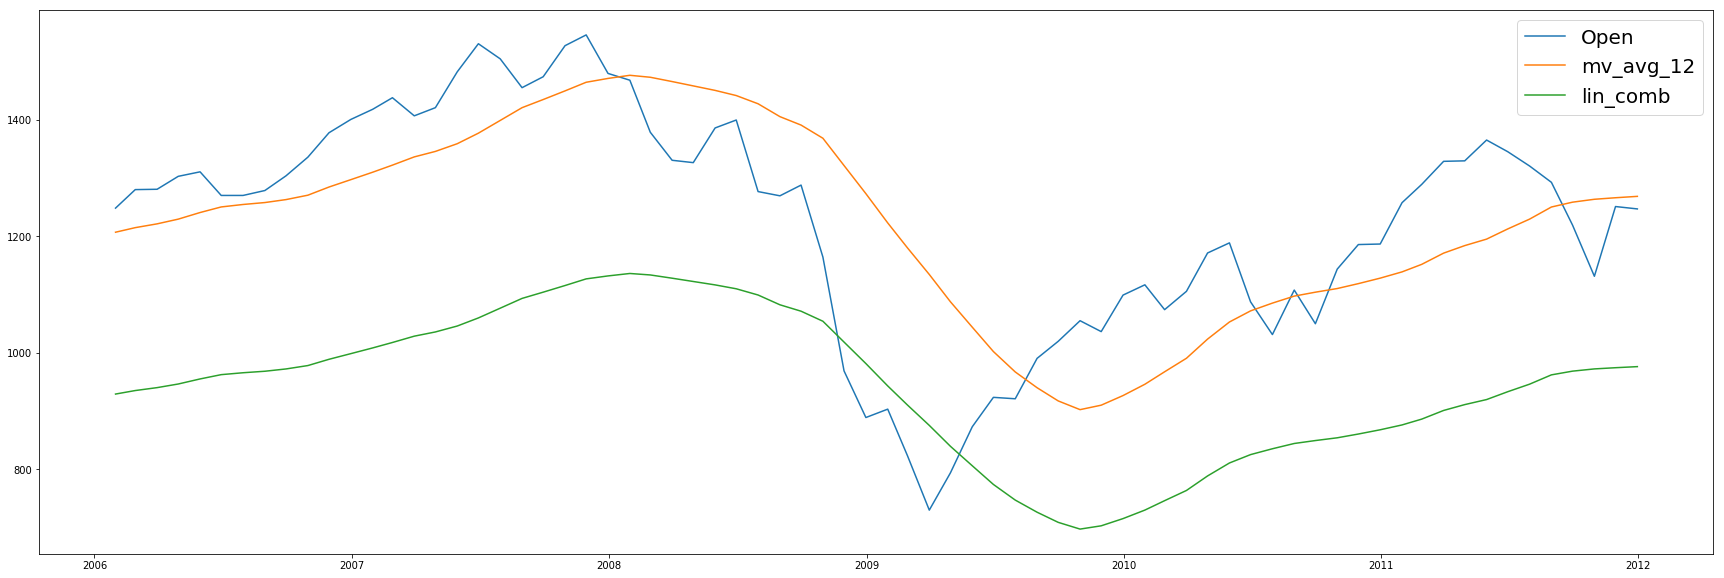

In [16]:
plt.figure(figsize=(30,10))
plt.plot(dfm1["fd_cm_open"],label="Open")
plt.plot(dfm1["mv_avg_12"],label="mv_avg_12")
plt.plot(-lin_comb(dfm1,coeffs)+dfm1["fd_cm_open"],label="lin_comb")
plt.legend(fontsize=20)
plt.show()

---------------------------------------------------------------------------------------------------------

### We have seen that, in order to choose the better custom method, it is necessary to forcast the market.

## Can we do it with LSTM neural networks and obtain a better yield on the testing period?

In [17]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

We reshape the data in order to feed it to the LSTM NN, at each step we want to predict the opening price of the first day of the next month (in order to decide wether to stay in the market or not)

In [18]:
scaler=MinMaxScaler(feature_range=(0,1))
dg=pd.DataFrame(scaler.fit_transform(dfm[["High","Low","Open","Close","Volume","fd_cm_open",\
                                          "mv_avg_12","mv_avg_24","fd_nm_open"]].values))
dg0=dg[[0,1,2,3,4,5,6,7]]
window=4
dfw=create_window(dg0,window)
print dfw.shape
X_dfw=np.reshape(dfw.values,(dfw.shape[0],window+1,8))
print X_dfw.shape
print dfw.iloc[:4,:]
print X_dfw[0,:,:]

y_dfw=np.array(dg[8][window:])

(440, 40)
(440, 5, 8)
          0         1         2         3         4         5         6  \
0  0.000000  0.000000  0.000000  0.000000  0.000893  0.000000  0.003542   
1  0.005053  0.005110  0.005180  0.005134  0.001252  0.005639  0.002118   
2  0.007630  0.007737  0.007810  0.007680  0.001305  0.008760  0.001307   
3  0.008219  0.008411  0.008387  0.008288  0.001010  0.009958  0.000482   

          7         0         1    ...            6         7         0  \
0  0.008064  0.005053  0.005110    ...     0.000482  0.004628  0.011912   
1  0.006613  0.007630  0.007737    ...     0.000000  0.003815  0.013394   
2  0.005529  0.008219  0.008411    ...     0.000007  0.003270  0.013602   
3  0.004628  0.011912  0.012082    ...     0.000149  0.002876  0.008884   

          1         2         3         4         5         6         7  
0  0.012082  0.012053  0.011950  0.001183  0.012626  0.000000  0.003815  
1  0.013716  0.013614  0.013519  0.001115  0.015347  0.000007  0.003270  
2  0

In [19]:
X_trainw=X_dfw[:-mtest-1,:,:]
X_testw=X_dfw[-mtest-1:,:,:]
y_trainw=y_dfw[:-mtest-1]
y_testw=y_dfw[-mtest-1:]

In [20]:
def model_lstm(window,features):
    
    model=Sequential()
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200, input_shape=(window,features), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam')
    
    
    return model

Train on 367 samples, validate on 73 samples
Epoch 1/500
367/367 [==============================] - 4s 10ms/step - loss: 0.0267 - val_loss: 0.0221
Epoch 2/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0462 - val_loss: 0.0077
Epoch 3/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0464 - val_loss: 0.0652
Epoch 4/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0089 - val_loss: 0.0223
Epoch 5/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0068
Epoch 6/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0043 - val_loss: 0.0081
Epoch 7/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0063
Epoch 8/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0066
Epoch 9/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0074
Epoch 10/500
367/367 [=======================

Epoch 81/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 82/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0010 - val_loss: 0.0035
Epoch 83/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0039
Epoch 84/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0051
Epoch 85/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0078
Epoch 86/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0031 - val_loss: 0.0067
Epoch 87/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0092
Epoch 88/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 89/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 90/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0022

367/367 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 161/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 162/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 163/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0026 - val_loss: 0.0062
Epoch 164/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 165/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 166/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 167/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 168/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 169/500
367/367 [==============================] - 1s 2ms/step - loss: 0.0061 - v

367/367 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 240/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 241/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 242/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0051
Epoch 243/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 244/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 245/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 246/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 247/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 248/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0016 - v

367/367 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0073
Epoch 319/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0080
Epoch 320/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0071
Epoch 321/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0068
Epoch 322/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0071
Epoch 323/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0065
Epoch 324/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 0.0064
Epoch 325/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0061
Epoch 326/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 0.0060
Epoch 327/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0019 - v

367/367 [==============================] - ETA: 0s - loss: 0.0016 - 1s 3ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 398/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 399/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 400/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 401/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 402/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 403/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 404/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 405/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 406/500
367/367 [==============================] - 1s 3m

367/367 [==============================] - 1s 3ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 477/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 478/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 479/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 480/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0038
Epoch 481/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 482/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 483/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 484/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 485/500
367/367 [==============================] - 1s 3ms/step - loss: 0.0012 - v

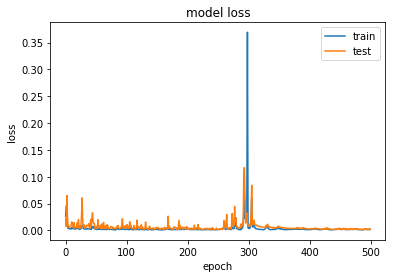

In [21]:
model=model_lstm(window+1,8)
history=model.fit(X_trainw,y_trainw,epochs=500, batch_size=24, validation_data=(X_testw, y_testw), \
                  verbose=1, callbacks=[],shuffle=False)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [22]:
y_pr=model.predict(X_trainw)

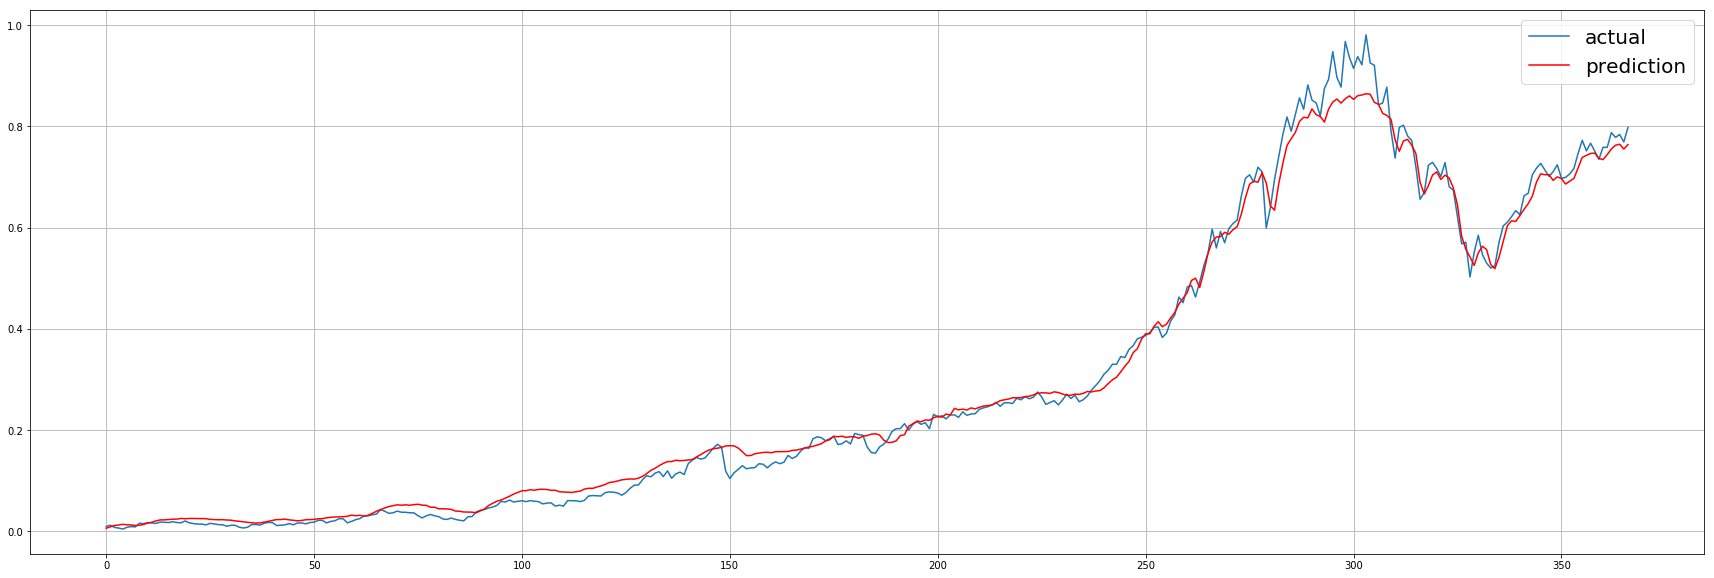

In [23]:
ran=len(y_pr)
aa=range(ran)
plt.figure(figsize=(30,10))
plt.plot(aa, y_trainw[:ran], label="actual")
plt.plot(aa, y_pr[:ran], 'r', label="prediction")
#plt.plot(aa[:-1], y_pr[1:ran], 'g', label="shifter prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.show()

In [24]:
y_pred=model.predict(X_testw)

We stay in the market when the predicted price for the next month is greater than the current price and stay out otherwise. The vector w indicates the "in months" (as 1s) and "out months (as 0s)

In [25]:
v=np.diff(y_pred.reshape(y_pred.shape[0]),1)
w=np.maximum(np.sign(v),0)

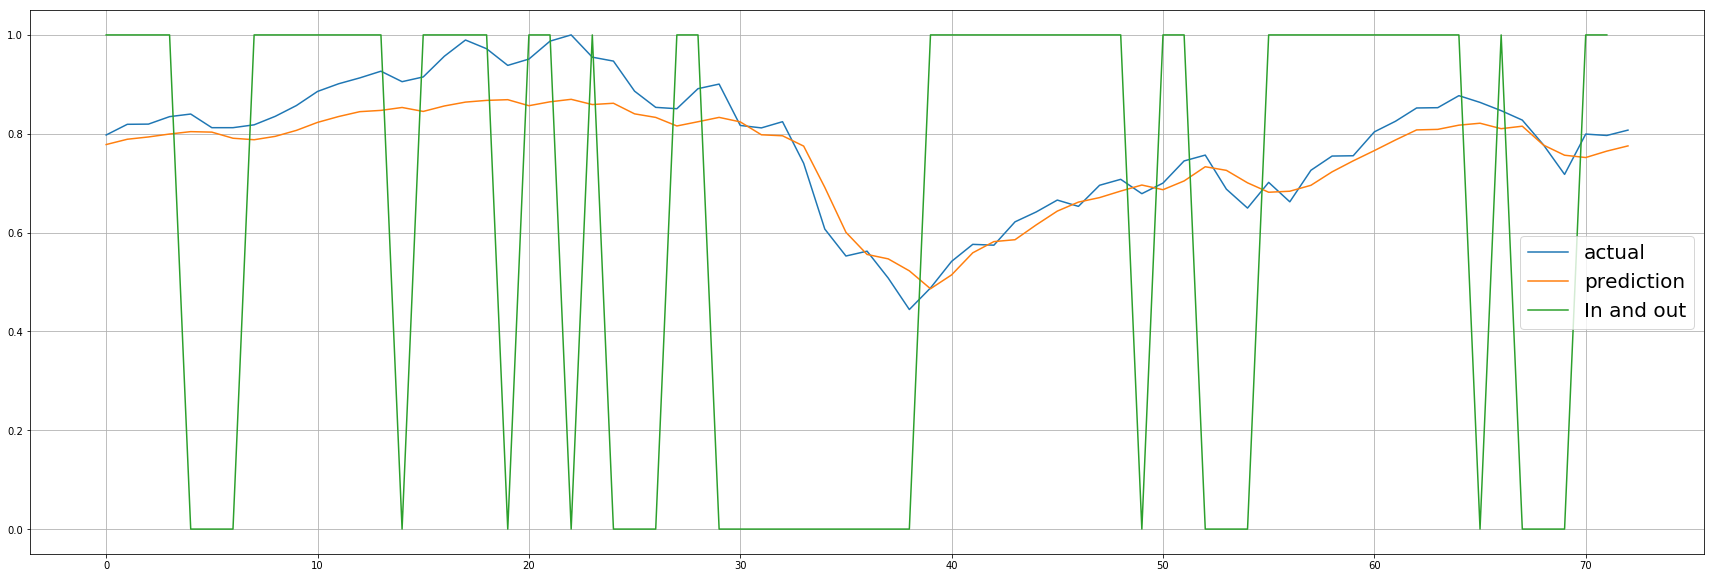

In [26]:
ran=len(y_pred)
aa=range(ran)
plt.figure(figsize=(30,10))
plt.plot(aa, y_testw[:ran], label="actual")
plt.plot(aa, y_pred[:ran], label="prediction")
plt.plot(w,label="In and out")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.show()

In [27]:
print "Gross yield of LSTM method :",(round((np.array(dfm1["rapp"])*w+1-w).prod(),3)-1)*100,"%"
print "Net yield of LSTM method :",(round(yield_prod_net2(dfm1,w),3)-1)*100,"%"

Gross yield of LSTM method : 126.8 %
Net yield of LSTM method : 80.5 %


### Both the gross and net yields are far better than before!